# Model creation (alternative)

Use this notebook to create a model using a specific method, but with data coming from the alternative calibration method

- [Polynomial regression](#polynomial-regression)

# Setup

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

import common_functions as cf

import importlib

importlib.reload(cf)

# Parameters
SENSOR_LAG = 25 # ms
ARRAY_W = 2
ARRAY_H = 2
NR_SUBREGIONS = 3
ARRAY_SIZE = ARRAY_W * ARRAY_H
ARRAY_SIZE_SUB = (ARRAY_W + (ARRAY_W - 1) * (NR_SUBREGIONS - 1)) * (ARRAY_H + (ARRAY_H - 1) * (NR_SUBREGIONS - 1))
NAME_PREFIX = lambda i: f"H1_5-s{i}-20231218-005"
MODEL_NAME_Z = f"table_calibration/2x2_grid_subsampling_x{NR_SUBREGIONS}_08032024_schroef2"
MODEL_NAME_XY = f"table_calibration/2x2_grid_xy_subsampling_x{NR_SUBREGIONS}_08032024_schroef2"

# Splitting the dataset
## Converting to DF and splitting

In [2]:
importlib.reload(cf)

data_columns = [f'X{i}' for i in range(ARRAY_SIZE)] + [f'Y{i}' for i in range(ARRAY_SIZE)] + [f'Z{i}' for i in range(ARRAY_SIZE)]

all_data = []

for i, name in enumerate([MODEL_NAME_Z, MODEL_NAME_XY]):
    TFdata = cf.read_csv_file(f"../data/raw/TF/{name}.csv") 
    sensordata = cf.read_csv_file(f'../data/raw/sensor/{name}.csv')
    
    # First unwrap the sensordata
    sensordata = cf.unwrap_data(sensordata, data_columns)

    # Time sync
    data = cf.time_sync_data(sensordata, TFdata, SENSOR_LAG / 1000)

    # Remove mean of first 100 samples
    data = cf.offset_data(data, data_columns, 100)

    # Remove rows containing NaN values
    data = data.dropna()
    
    # Remove other columns
    data = data.drop(columns=['t_robot', 'R_x', 'R_y', 'R_z'])

    all_data.append(data)
    
print("Data loaded")
all_data[0].info() # Z-calibration
all_data[1].info() # XY-calibration

Data loaded
<class 'pandas.core.frame.DataFrame'>
Int64Index: 59476 entries, 1 to 59476
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   59476 non-null  int64  
 1   t_wall  59476 non-null  float64
 2   X0      59476 non-null  float64
 3   Y0      59476 non-null  float64
 4   Z0      59476 non-null  float64
 5   X1      59476 non-null  float64
 6   Y1      59476 non-null  float64
 7   Z1      59476 non-null  float64
 8   X2      59476 non-null  float64
 9   Y2      59476 non-null  float64
 10  Z2      59476 non-null  float64
 11  X3      59476 non-null  float64
 12  Y3      59476 non-null  float64
 13  Z3      59476 non-null  float64
 14  F_x     59476 non-null  float64
 15  F_y     59476 non-null  float64
 16  F_z     59476 non-null  float64
 17  T_x     59476 non-null  float64
 18  T_y     59476 non-null  float64
 19  T_z     59476 non-null  float64
 20  X       59476 non-null  float64
 21  Y       59476 non-null 

[[0. 0.]
 [0. 1.]
 [0. 2.]
 [0. 3.]
 [1. 0.]
 [1. 1.]
 [1. 2.]
 [1. 3.]
 [2. 0.]
 [2. 1.]
 [2. 2.]
 [2. 3.]
 [3. 0.]
 [3. 1.]
 [3. 2.]
 [3. 3.]]


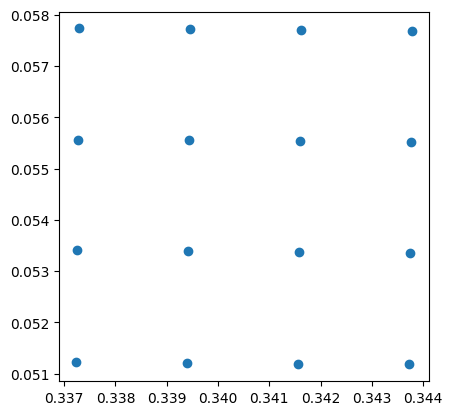

In [3]:
# Boundary search of where the x,y is valid
z_filter = all_data[0]['Z'].copy().to_numpy()
z_filter[all_data[0]['Z'] - np.min(z_filter) > 0.003] = 0
z_filter[z_filter.nonzero()] = 1
boundaries = np.diff(z_filter).nonzero()[0].reshape(-1, 2)

data_points_integer = np.zeros((ARRAY_SIZE_SUB, 2))
for i in range(ARRAY_SIZE):
    for j in range(ARRAY_SIZE):
        data_points_integer[i * (NR_SUBREGIONS + 1) + j][0] = i
        data_points_integer[i * (NR_SUBREGIONS + 1) + j][1] = j

print(data_points_integer)

# Now take the average of the boundaries, applied as a filter to X and Y
data_points = np.zeros((ARRAY_SIZE_SUB, 2))
assert boundaries.shape[0] == ARRAY_SIZE_SUB

for i in range(ARRAY_SIZE_SUB):
    data_points[i][0] = all_data[0]['X'].to_numpy()[boundaries[i][0]:boundaries[i][1]].mean()
    data_points[i][1] = all_data[0]['Y'].to_numpy()[boundaries[i][0]:boundaries[i][1]].mean()
    
plt.scatter(data_points[:,0], data_points[:,1])
plt.gca().set_aspect('equal', adjustable='box')

## Split the data into subsets based on these points
Based on closest distance

In [4]:

all_data_subsets = []

for data in all_data:
    
    # Fetch distances from the samples in data to each and every data_point
    distances = np.zeros((len(data), ARRAY_SIZE_SUB))
    for i, point in enumerate(data_points):
        distances[:,i] = np.sqrt((data['X'] - point[0])**2 + (data['Y'] - point[1])**2)

    
    # Find the closest data_point for each sample
    closest = np.argmin(distances, axis=1)
    
    # Now separate 'data' into subsets according to closest
    data_subsets = [data.copy() for i in range(ARRAY_SIZE_SUB)]
    #data_subsets = []
    for i in range(ARRAY_SIZE_SUB):
        
        indices_to_zero = closest != i
        # data_subsets[i].loc[indices_to_zero, 'X'] = np.nan
        # data_subsets[i].loc[indices_to_zero, 'Y'] = np.nan
        # data_subsets[i].loc[indices_to_zero, 'Z'] = np.nan
        # data_subsets[i].loc[indices_to_zero, 'F_x'] = np.nan
        # data_subsets[i].loc[indices_to_zero, 'F_y'] = np.nan
        # data_subsets[i].loc[indices_to_zero, 'F_z'] = np.nan
        
        # data_sb = data[closest == i]
        # data_sb.reset_index(drop=True, inplace=True)
        # data_subsets.append(data_sb)
        
        # print(data_subsets[i].info())
        
        # Also set indices to zero if the distance if too large
        # indices_to_zero = distances[:,i] > 0.0005
        # print(sum(indices_to_zero))
        # data_subsets[i].loc[indices_to_zero, 'X'] = np.nan
        # data_subsets[i].loc[indices_to_zero, 'Y'] = np.nan
        # data_subsets[i].loc[indices_to_zero, 'Z'] = np.nan
        # data_subsets[i].loc[indices_to_zero, 'F_x'] = np.nan
        # data_subsets[i].loc[indices_to_zero, 'F_y'] = np.nan
        # data_subsets[i].loc[indices_to_zero, 'F_z'] = np.nan
        
    # data_subsets = [data[closest == i] for i in range(ARRAY_SIZE_SUB)]
    
    all_data_subsets.append(data_subsets)  

In [5]:
for data_subset in all_data_subsets:
  for j in range(ARRAY_SIZE_SUB):
      data = data_subset[j]
      
      data['F_xy'] = np.sqrt(data['F_x']**2 + data['F_y']**2)
      data['F_m'] = np.sqrt(data['F_x']**2 + data['F_y']**2 + data['F_z']**2)
      
      for i in range(ARRAY_SIZE):
          data[f'XY{i}'] = np.sqrt(data[f'X{i}']**2 + data[f'Y{i}']**2)
          data[f'M{i}'] = np.sqrt(data[f'X{i}']**2 + data[f'Y{i}']**2 + data[f'Z{i}']**2)

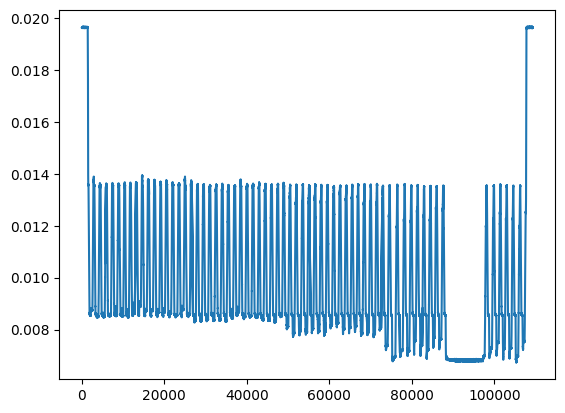

In [6]:
plt.plot(all_data[1]['Z'])

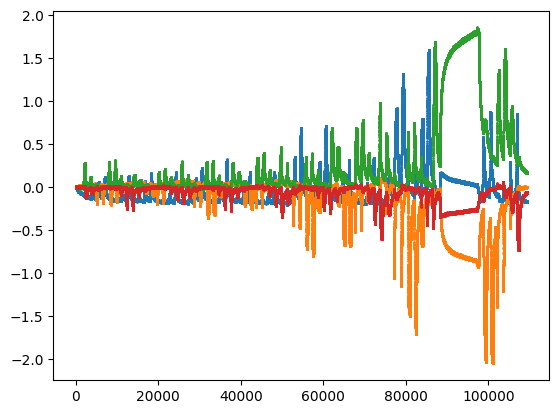

In [7]:
plt.plot(all_data_subsets[1][4]['Z0'], 'o', markersize=1)
plt.plot(all_data_subsets[1][4]['Z1'], 'o', markersize=1)
plt.plot(all_data_subsets[1][4]['Z2'], 'o', markersize=1)
plt.plot(all_data_subsets[1][4]['Z3'], 'o', markersize=1)
# plt.plot(all_data_subsets[1][4]['F_z'], 'o', markersize=1)
plt.show()

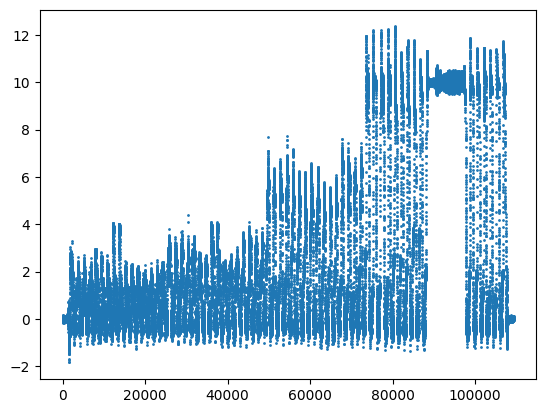

In [8]:
plt.plot(all_data_subsets[1][4]['F_z'], 'o', markersize=1)
plt.show()

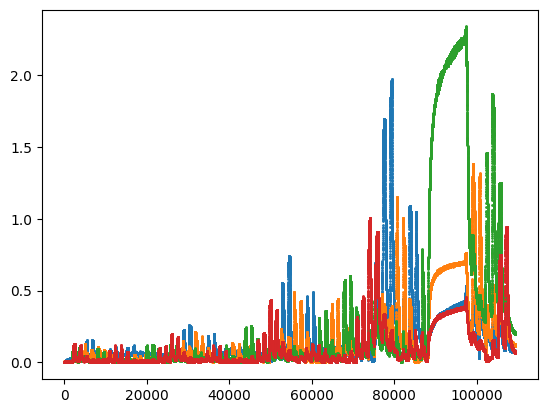

In [9]:
ind0 = 0
ind1 = -1

plt.plot(all_data_subsets[1][4]['XY0'].to_numpy()[ind0:ind1], 'o', markersize=1)
plt.plot(all_data_subsets[1][4]['XY1'].to_numpy()[ind0:ind1], 'o', markersize=1)
plt.plot(all_data_subsets[1][4]['XY2'].to_numpy()[ind0:ind1], 'o', markersize=1)
plt.plot(all_data_subsets[1][4]['XY3'].to_numpy()[ind0:ind1], 'o', markersize=1)
# plt.plot(all_data_subsets[1][4]['F_xy'].to_numpy()[ind0:ind1], 'o', markersize=1)
plt.show()

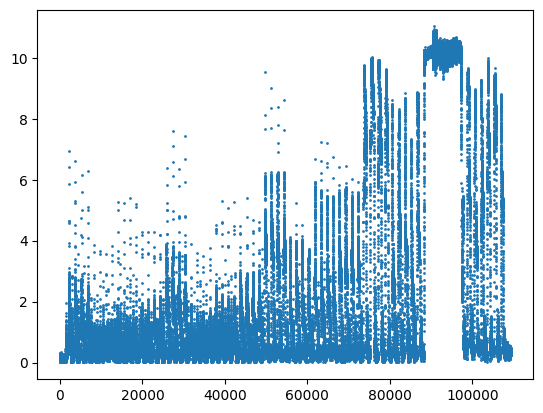

In [10]:
plt.plot(all_data_subsets[1][4]['F_xy'].to_numpy()[ind0:ind1], 'o', markersize=1)
plt.show()

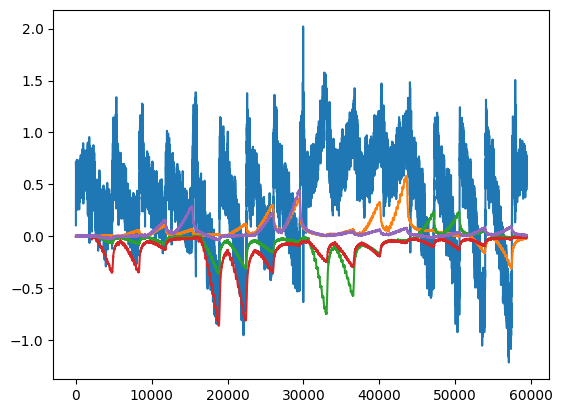

In [11]:
plt.plot(all_data_subsets[0][4]['F_y'])
plt.plot(all_data_subsets[0][4]['Y0'])
plt.plot(all_data_subsets[0][4]['Y1'])
plt.plot(all_data_subsets[0][4]['Y2'])
plt.plot(all_data_subsets[0][4]['Y3'])

plt.show()

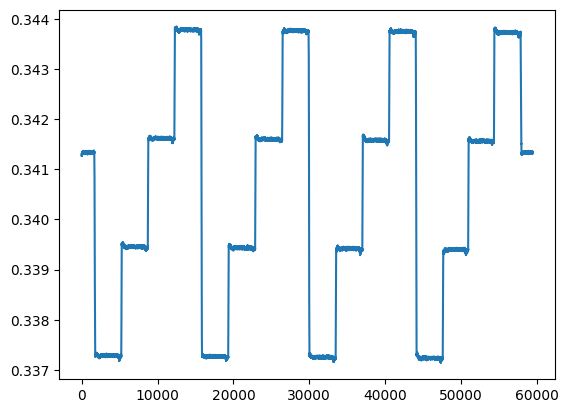

In [12]:
plt.plot(all_data_subsets[0][0]['X'])

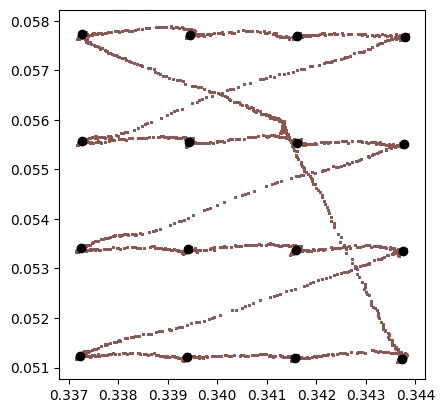

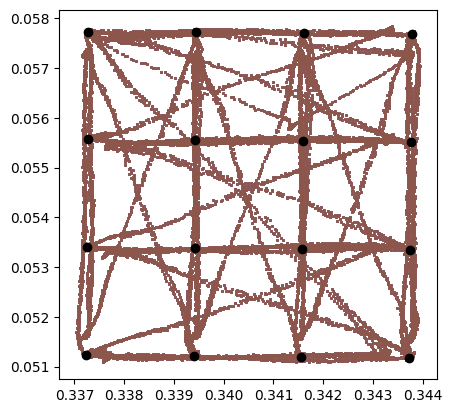

In [13]:

for i in range(ARRAY_SIZE_SUB):
  plt.scatter(all_data_subsets[0][i]['X'], all_data_subsets[0][i]['Y'], s=1)
  
plt.scatter(data_points[:,0], data_points[:,1], color='black')
# plt.xlim(0.3,0.35)
# plt.ylim(0.05,0.15)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

for i in range(ARRAY_SIZE_SUB):
  plt.scatter(all_data_subsets[1][i]['X'], all_data_subsets[1][i]['Y'], s=1)
  
plt.scatter(data_points[:,0], data_points[:,1], color='black')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Making the ARRAY_SIZE_SUB models

In [61]:
all_data_transformed = []
z_calibration_indices = []

# Transforming the data
for i in range(ARRAY_SIZE_SUB):
    
    Z_calibration = all_data_subsets[0][i]
    XY_calibration = all_data_subsets[1][i]
    
    z_calibration_indices.append(len(Z_calibration))
    
    # Concat them together    
    data = pd.concat([Z_calibration, XY_calibration], axis=0)

    all_data_transformed.append(data)

In [62]:
# for j in range(ARRAY_SIZE_SUB):
#     data = all_data_transformed[j]
    
#     data['F_xy'] = np.sqrt(data['F_x']**2 + data['F_y']**2)
#     data['F_m'] = np.sqrt(data['F_x']**2 + data['F_y']**2 + data['F_z']**2)
    
#     for i in range(ARRAY_SIZE):
#         data[f'XY{i}'] = np.sqrt(data[f'X{i}']**2 + data[f'Y{i}']**2)
#         data[f'M{i}'] = np.sqrt(data[f'X{i}']**2 + data[f'Y{i}']**2 + data[f'Z{i}']**2)
        
all_data_transformed[0].info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 168803 entries, 1 to 109330
Data columns (total 33 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   index   168803 non-null  int64  
 1   t_wall  168803 non-null  float64
 2   X0      168803 non-null  float64
 3   Y0      168803 non-null  float64
 4   Z0      168803 non-null  float64
 5   X1      168803 non-null  float64
 6   Y1      168803 non-null  float64
 7   Z1      168803 non-null  float64
 8   X2      168803 non-null  float64
 9   Y2      168803 non-null  float64
 10  Z2      168803 non-null  float64
 11  X3      168803 non-null  float64
 12  Y3      168803 non-null  float64
 13  Z3      168803 non-null  float64
 14  F_x     168803 non-null  float64
 15  F_y     168803 non-null  float64
 16  F_z     168803 non-null  float64
 17  T_x     168803 non-null  float64
 18  T_y     168803 non-null  float64
 19  T_z     168803 non-null  float64
 20  X       168803 non-null  float64
 21  Y       16

In [63]:
def simulate_forces(taxel_models):
  # Simulate forces to plot model

  for j, letter in enumerate(['X', 'Y', 'Z']):

      fig = plt.figure()
      gs = fig.add_gridspec(ARRAY_H, ARRAY_W)
      axs = cf.flatten_extend(gs.subplots())

      for i, model in enumerate(taxel_models):

          data = all_data[i]

          ax = axs[i]
          
          X = data[['X', 'Y', 'Z']].to_numpy()
          Y = model.predict(X)

          ax.scatter(data[letter], data[f'F_{letter.lower()}'], label='Data', s=0.1, c='r')
          ax.scatter(X[:, j], Y[:, j], label='Model Function', s=0.1, alpha=0.5)
          

      plt.show()


In [64]:
# Save taxel models (per taxel)
import dill

def save_taxel_models(taxel_models, subdir, name):
    
    while '/' in name:
        subdir = os.path.join(subdir, name.split('/')[0])
        name = name.split('/')[-1]
        
    save_path = os.path.join(os.getcwd(), '..', 'models', subdir)

    if not os.path.exists(save_path):
        os.makedirs(save_path)
        
    with open(os.path.join(save_path, name), 'wb') as f:
        dill.dump(taxel_models, f)
        

# Polynomial regression

Calibration achieved by pressing on all taxel one-by-one without silicone layer

In [65]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import PolynomialFeatures
from sklearn import set_config
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.compose import TransformedTargetRegressor

set_config(display='diagram')

COUPLE_COMPONENTS = True
POLY_DEGREE = 2

def create_regression_pipeline_and_fit(X, Y, debug = True, preserve_time=False, alpha=1.0):
  
  if preserve_time:
    split = int(len(X) * 0.99)
    X_train = X[:split]
    X_test = X[split:]
    y_train = Y[:split]
    y_test = Y[split:]
  else:
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

  pipeline = make_pipeline(
    PolynomialFeatures(degree=POLY_DEGREE, include_bias=False), 
    # LinearRegression()
    Ridge(alpha=alpha)
  )
  
  pipeline.fit(X_train, y_train)

  if debug:
    
    print("Score: ", pipeline.score(X_test, y_test))
    print("MSE: ", mean_squared_error(y_test, pipeline.predict(X_test)))
  
  return pipeline

class CombinedModel:
  
  def __init__(self, component_models) -> None:
    self.component_models = component_models
    
  def predict(self, X):
    
    predictions = []
    
    for i, model in enumerate(self.component_models):
      predictions.append(model.predict(X[:, i].reshape(-1, 1))[:, 0])
    
    return np.array(predictions).T

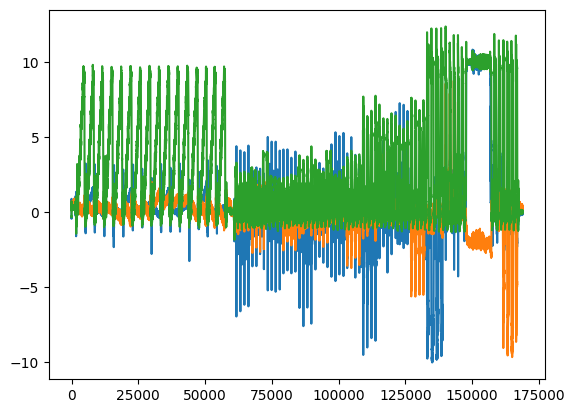

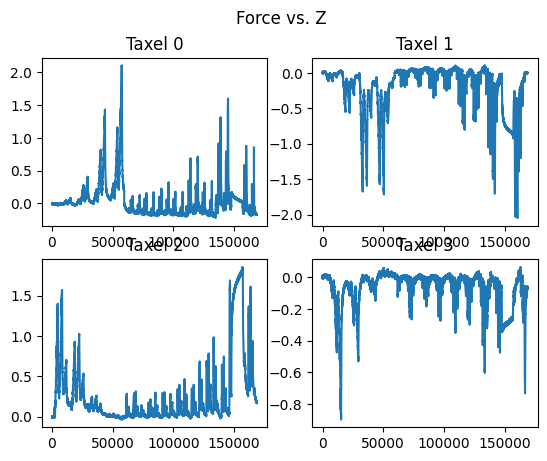

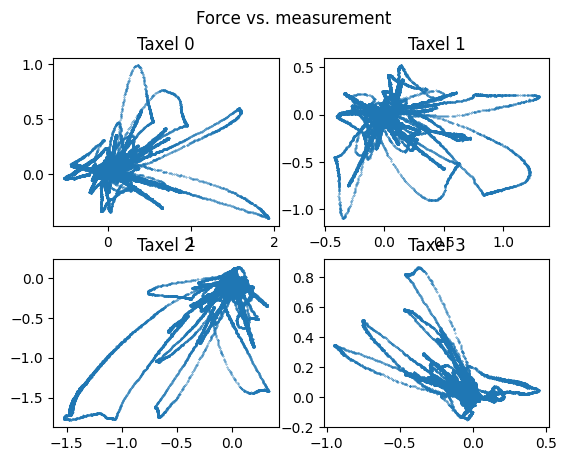

In [66]:
data = all_data_transformed[0]
min_index = 0
max_index = -1
# Plot the forces
plt.plot(data['F_x'].to_numpy()[min_index:max_index], markersize=1)
plt.plot(data['F_y'].to_numpy()[min_index:max_index], markersize=1)
plt.plot(data['F_z'].to_numpy()[min_index:max_index], markersize=1)

plt.show()

# Plot inputs (2x2 subplots)
fig, axs = plt.subplots(ARRAY_H, ARRAY_W)
fig.suptitle('Force vs. Z')
for i in range(ARRAY_SIZE):
    ax = axs[i // ARRAY_W, i % ARRAY_W]
    ax.plot(data[f'Z{i}'].to_numpy()[:max_index])
    ax.set_title(f"Taxel {i}")
plt.show()

fig, axs = plt.subplots(ARRAY_H, ARRAY_W)
fig.suptitle('Force vs. measurement')
for i in range(ARRAY_SIZE):
    ax = axs[i // ARRAY_W, i % ARRAY_W]
    ax.scatter(data[f'X{i}'].to_numpy()[:max_index], data[f'Y{i}'].to_numpy()[:max_index], s=0.1)
    ax.set_title(f"Taxel {i}")
plt.show()

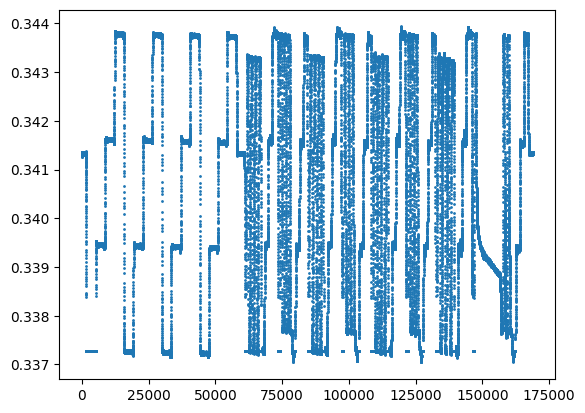

In [67]:
plt.plot(all_data_transformed[0]['X'].to_numpy()[:max_index], 'o', markersize=1)

# Predicction

Taxel 0
Score:  0.38851120063974476
MSE:  0.8368836775557806


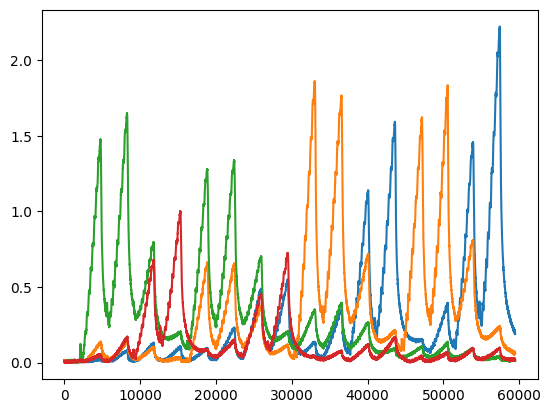

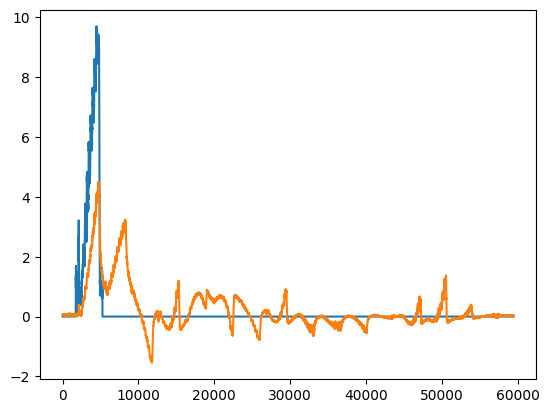

Taxel 1
Score:  0.5172033408366457
MSE:  0.7417319975027891
Taxel 2
Score:  0.7769113355803063
MSE:  0.30307034755839973
Taxel 3
Score:  0.8512524949110398
MSE:  0.2340436141690025


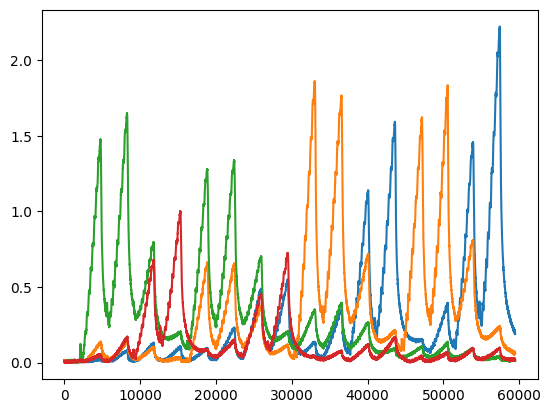

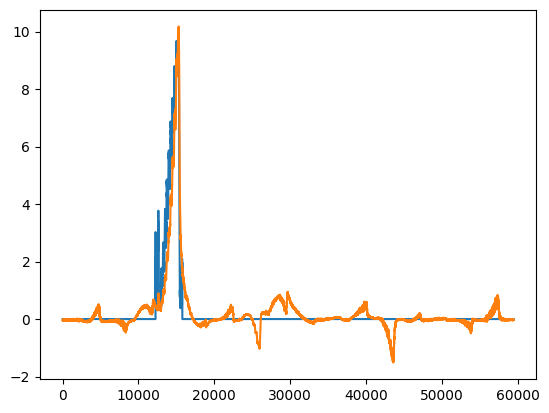

Taxel 4
Score:  0.45531168144530665
MSE:  0.7628646779894848
Taxel 5
Score:  0.37511320823381444
MSE:  0.8569750456012734
Taxel 6
Score:  0.6334111029488078
MSE:  0.5742049131875553
Taxel 7
Score:  0.7299792746889922
MSE:  0.388758061358399
Taxel 8
Score:  0.3322201133143604
MSE:  0.9865291358471961
Taxel 9
Score:  0.28256919244816114
MSE:  1.1255576593381988
Taxel 10
Score:  0.5246783712766008
MSE:  0.6522932454843088
Taxel 11
Score:  0.37306832223789255
MSE:  0.950319431298927
Taxel 12
Score:  0.3395554561450629
MSE:  0.9533666969324747


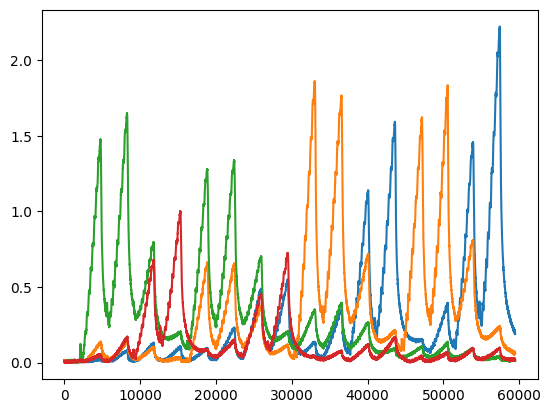

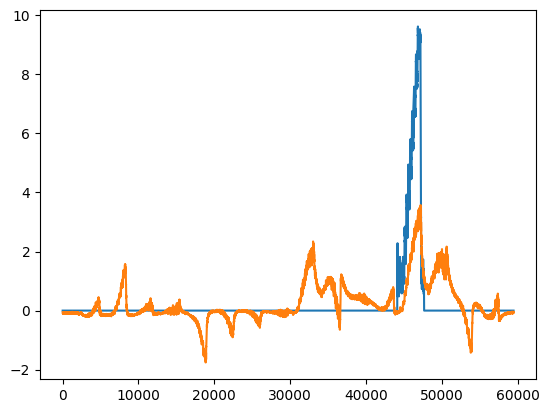

Taxel 13
Score:  0.32668698151110054
MSE:  0.7918685682800589
Taxel 14
Score:  0.6760138736528611
MSE:  0.4730480344602689
Taxel 15
Score:  0.7253006669769224
MSE:  0.38194053139320266


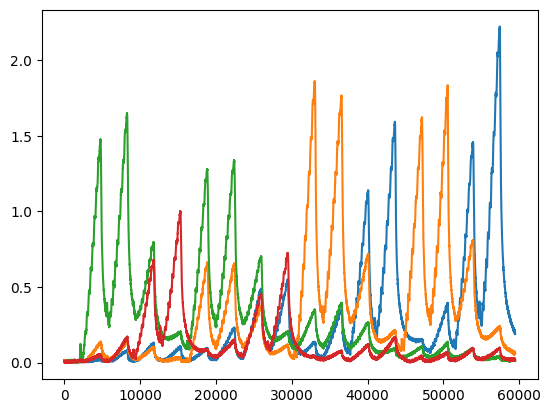

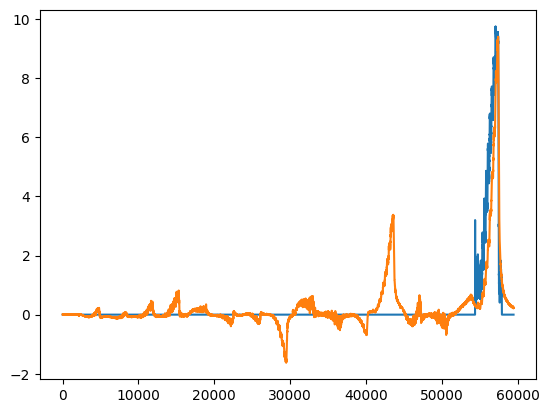

In [23]:

z_taxel_models = []


for i in range(ARRAY_SIZE_SUB):
    
    index = z_calibration_indices[i]
        
    print(f"Taxel {i}")

    data = all_data_transformed[i]
    # Replace nan by zero
    data = data.fillna(0)
    
    X = data[[f'M{k}' for k in range(ARRAY_SIZE)]].to_numpy()[:index]
    Y = data[['F_m']].to_numpy()[:index]
    
    component_model = create_regression_pipeline_and_fit(X, Y, preserve_time=False, alpha=1)
    
    Y_pred = component_model.predict(X)

    if i == 0 or i == 3 or i == 12 or i == 15:
        plt.plot(X)
        plt.show()
        
        plt.plot(Y)
        
        plt.plot(Y_pred)
        plt.show()
    
    z_taxel_models.append(component_model)

In [136]:
print(MODEL_NAME_Z)
print(z_taxel_models[0])
save_taxel_models(z_taxel_models, F'PolyLinear-Deg{POLY_DEGREE}', MODEL_NAME_Z)

table_calibration/2x2_grid_subsampling_x3_08032024_schroef2
Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('ridge', Ridge(alpha=1))])


/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


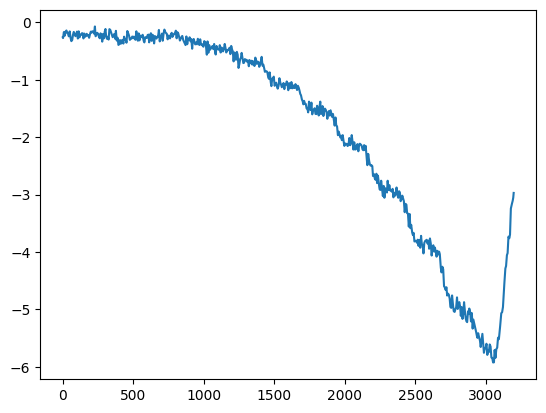

In [121]:

plt.plot(z_taxel_models[3].predict(all_data_transformed[0][[f'Z{k}' for k in range(ARRAY_SIZE)]][:3200]))


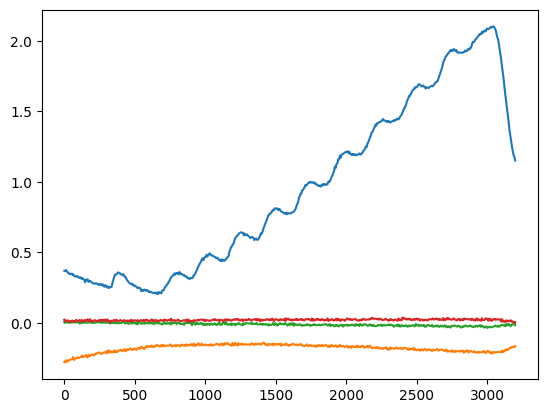

In [122]:
plt.plot(all_data_transformed[15][[f'Z{k}' for k in range(ARRAY_SIZE)]][:3200])


Taxel 0


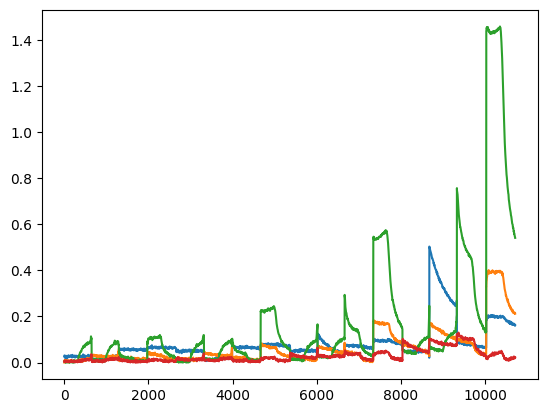

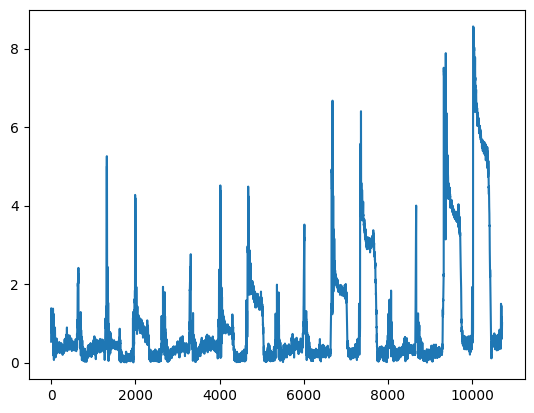

Score:  0.8313505817448463
MSE:  0.31818624575820315

Taxel 1


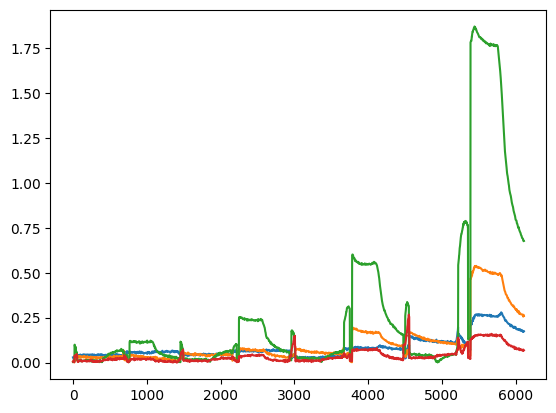

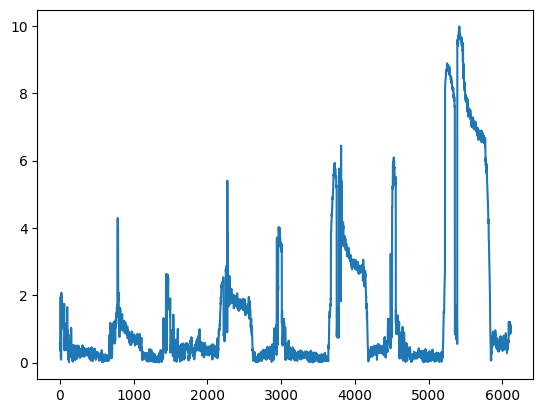

Score:  0.8857222804104485
MSE:  0.6122281484343385

Taxel 2


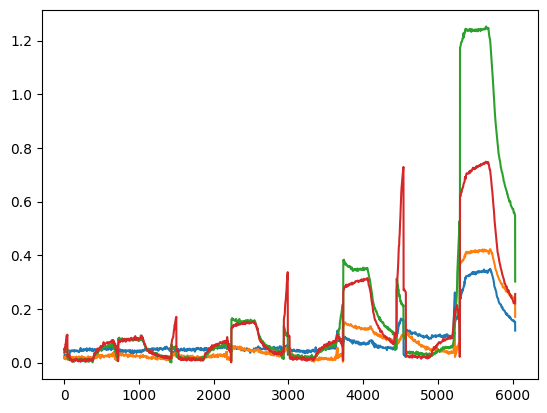

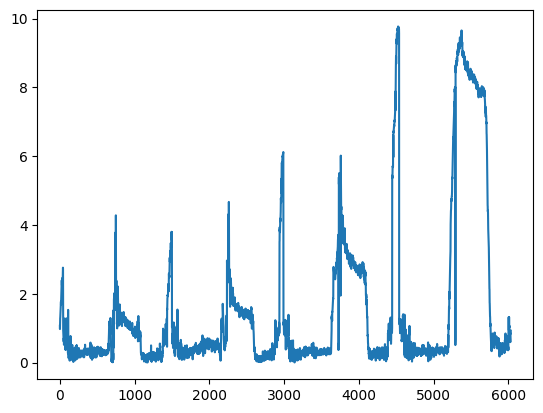

Score:  0.8882653965795946
MSE:  0.5953734795984384

Taxel 3


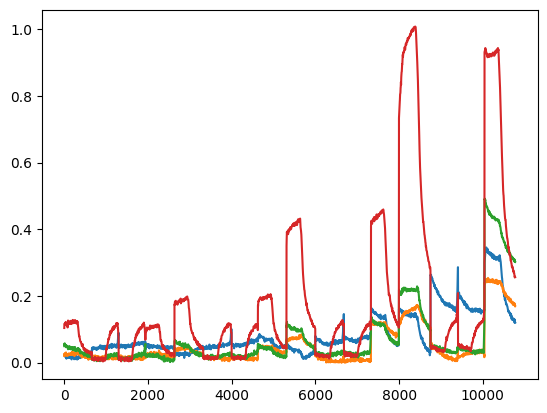

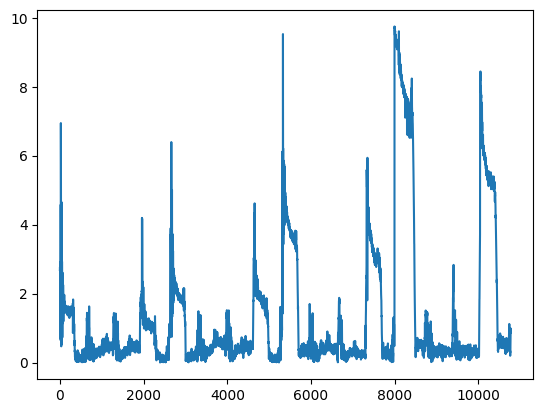

Score:  0.8579166441299547
MSE:  0.5138929656290054

Taxel 4


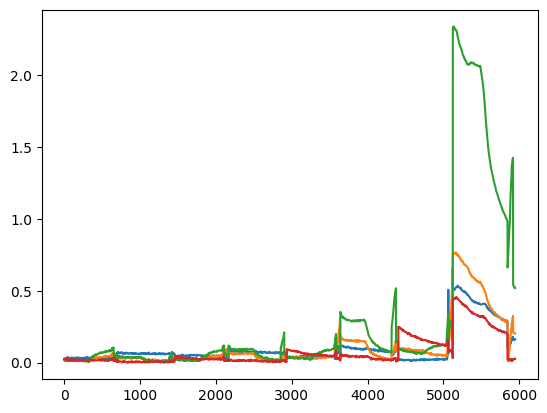

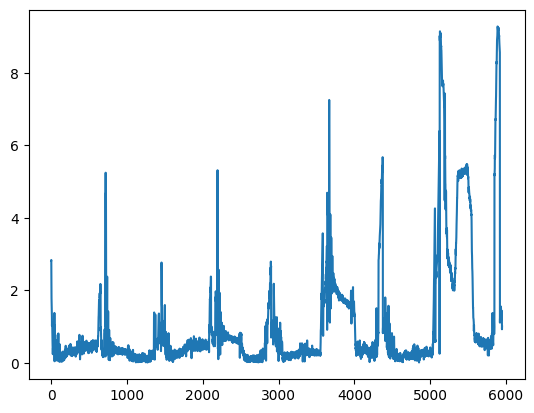

Score:  0.7944406368161092
MSE:  0.5444024717848651

Taxel 5


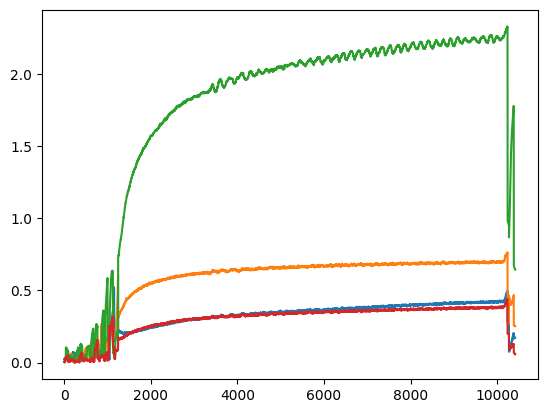

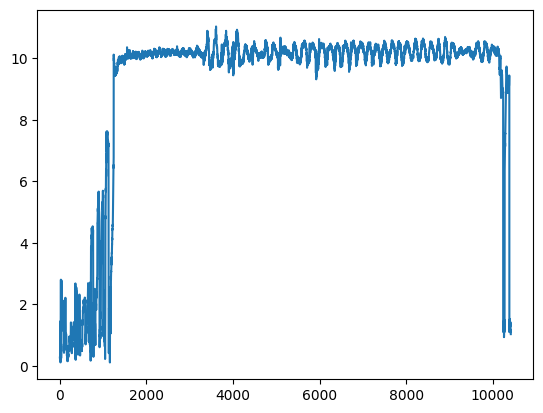

Score:  0.9488471901360993
MSE:  0.3586969042267079

Taxel 6


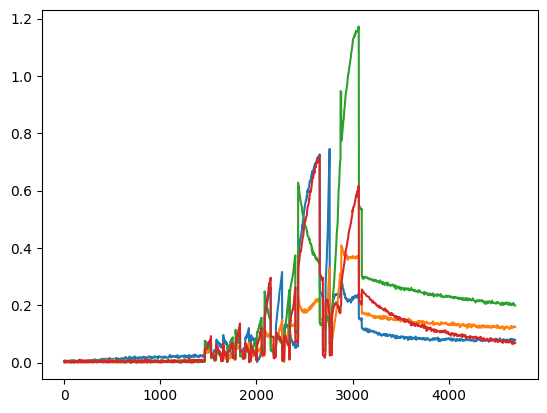

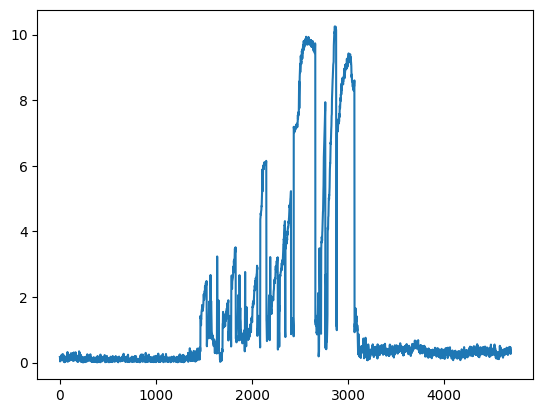

Score:  0.871711764487624
MSE:  0.9633489038024974

Taxel 7


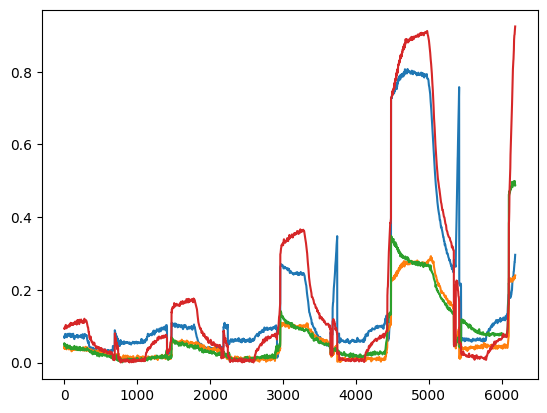

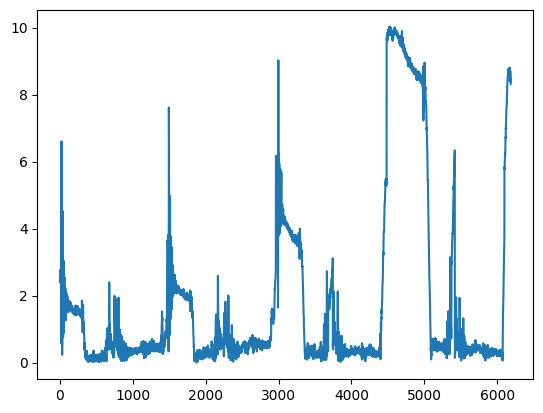

Score:  0.9052380117810005
MSE:  0.693066901890308

Taxel 8


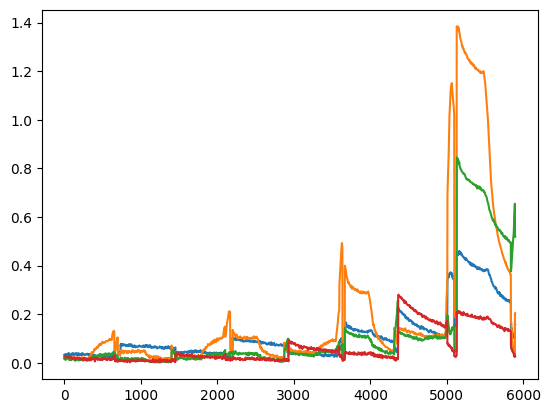

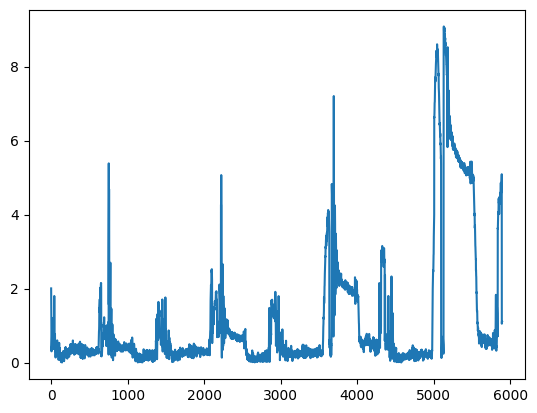

Score:  0.859414260622034
MSE:  0.49431245529030476

Taxel 9


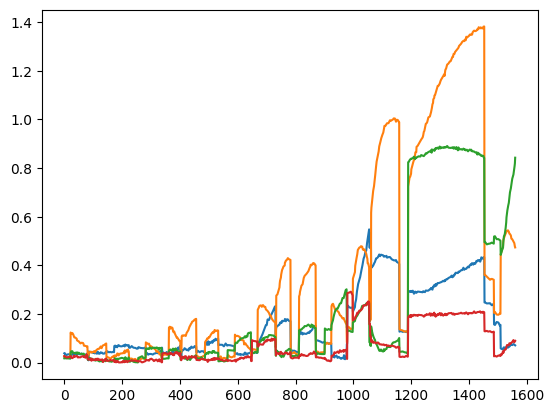

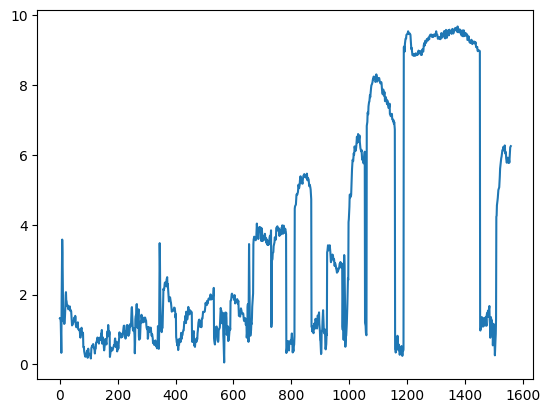

Score:  0.9505443215871087
MSE:  0.5233383591672089

Taxel 10


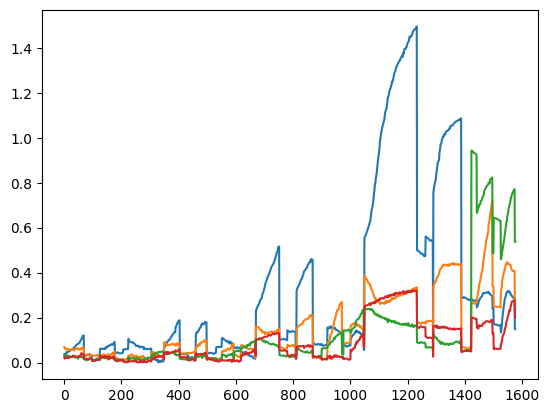

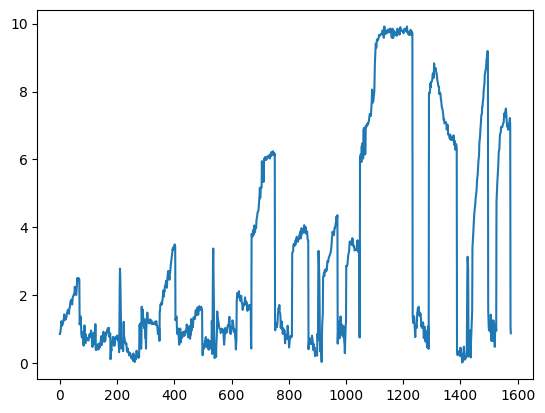

Score:  0.9015139380907025
MSE:  0.9247559715852035

Taxel 11


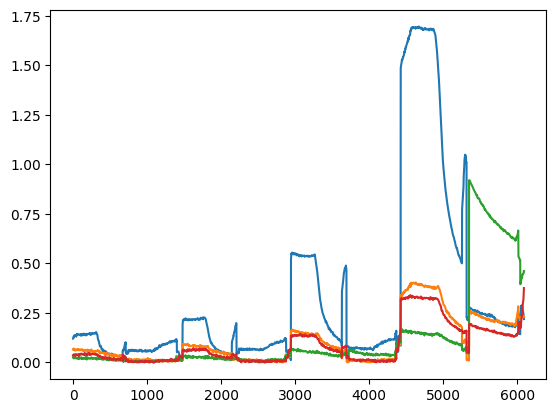

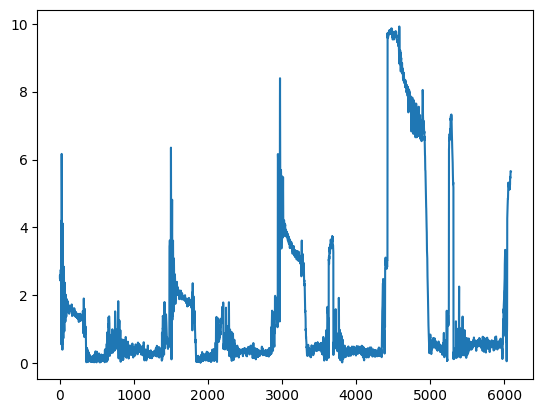

Score:  0.8489079043015763
MSE:  0.9382889070595811

Taxel 12


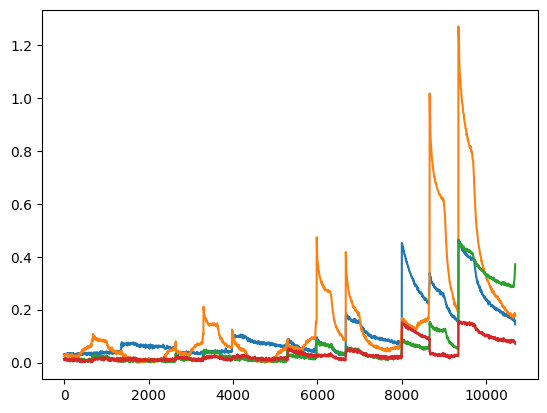

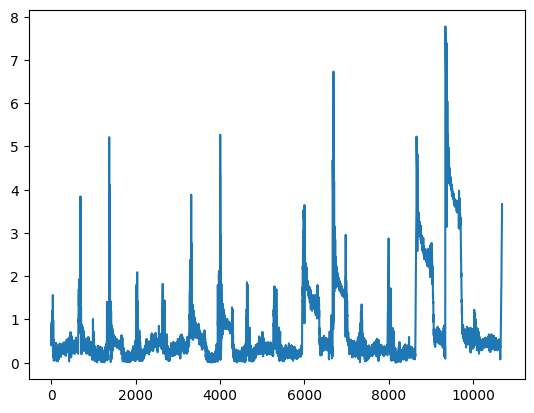

Score:  0.764469728160969
MSE:  0.2125031176616375

Taxel 13


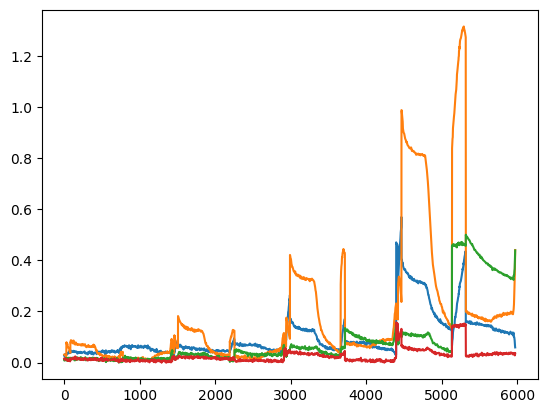

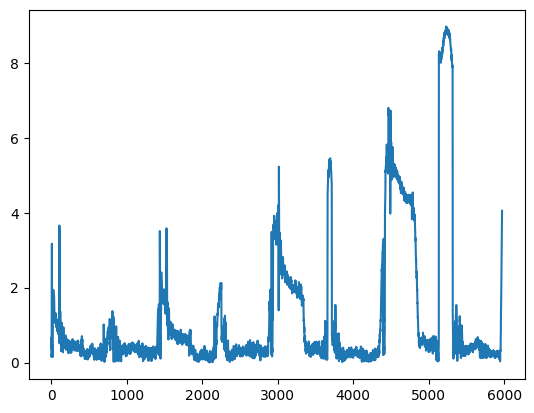

Score:  0.898961602942666
MSE:  0.35882906842674145

Taxel 14


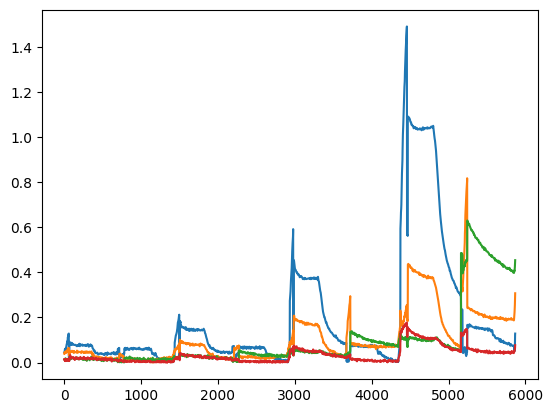

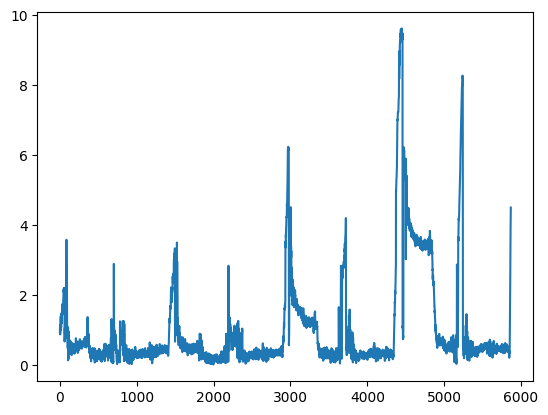

Score:  0.8408460492078569
MSE:  0.3470795584926026

Taxel 15


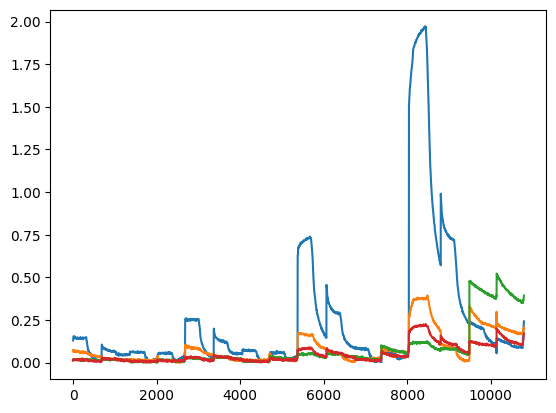

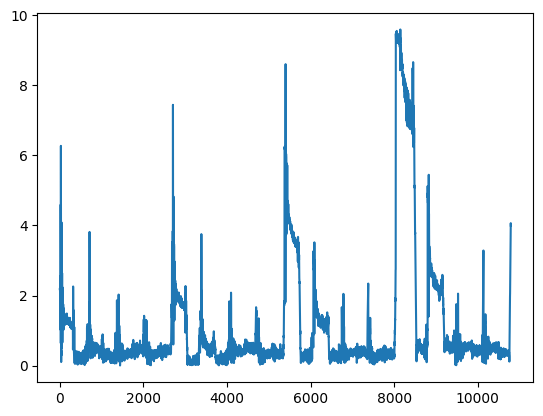

Score:  0.8556310194639426
MSE:  0.42983751706907053


In [129]:

xy_taxel_models = []

for j in range(ARRAY_SIZE_SUB):

    data = all_data_transformed[j]

    #replace nan by zero
    data = data.fillna(0)

    print(f"\nTaxel {j}")
    
    #  [f'Z{i}' for i in range(ARRAY_SIZE)]
    X = data[[f'XY{i}' for i in range(ARRAY_SIZE)]][z_calibration_indices[j]:].to_numpy()
    Y = data[[f'F_xy']][z_calibration_indices[j]:].to_numpy()
    
    if i == 0 or i == 3 or i == 12 or i == 15:
        plt.plot(X)
        plt.show()
        
        plt.plot(Y)
        plt.show()

    model = create_regression_pipeline_and_fit(X, Y)
    
    xy_taxel_models.append(model)

In [128]:
save_taxel_models(xy_taxel_models, F'PolyLinear-Deg{POLY_DEGREE}', MODEL_NAME_XY)

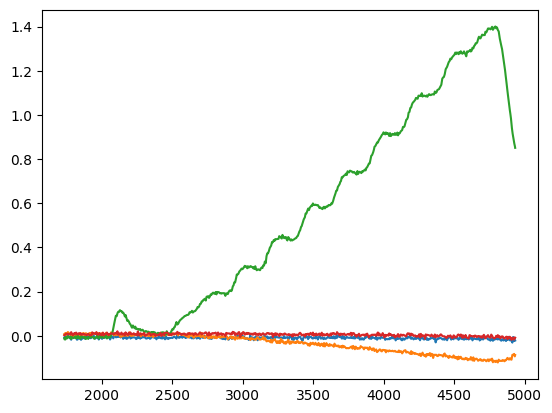

In [141]:
data = all_data_transformed[0][:3200]
plt.plot(data['Z0'])
plt.plot(data['Z1'])
plt.plot(data['Z2'])
plt.plot(data['Z3'])
plt.show()

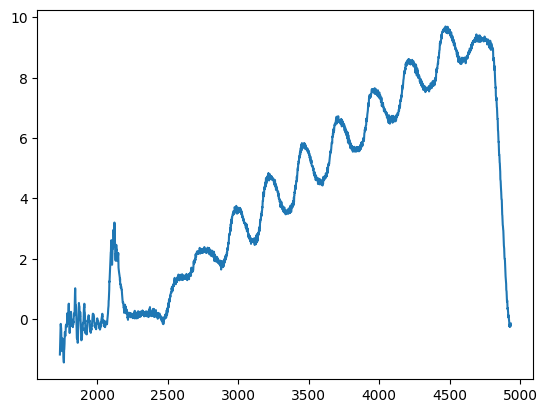

In [143]:
# plt.plot(data['F_z0'])
# plt.plot(data['F_z1'])
# plt.plot(data['F_z2'])
# plt.plot(data['F_z3'])
plt.plot(data['F_z'])
plt.show()

In [ ]:
plt.plot(data['F_x'])
